# Introduction to Bayesian Optimization with GPyOpt 


### Written by Javier Gonzalez, University of Sheffield.

*Last updated Friday, 11 March 2016.*

=====================================================================================================
1. **How to use GPyOpt?**

2. **The Basics of Bayesian Optimization**
    1. Gaussian Processes
    2. Acquisition functions
    3. Applications of Bayesian Optimization 

3. **1D optimization example**

4. **2D optimization example**

=====================================================================================================

## 1. How to use GPyOpt?

We start by loading GPyOpt and GPy.

In [46]:
%pylab inline  
import GPy
import GPyOpt
from numpy.random import seed

Populating the interactive namespace from numpy and matplotlib


GPyOpt is easy to use as a black-box functions optimizer. To start you only need: 

* Your favorite function $f$ to minimize. We use $f(x)=2x^2$ in this toy example, whose global minimum is at x=0.

In [47]:
def myf(x):
    return (2*x)**2 - 3*x

* A set of box constrains, the interval [-1,1] in our case. You can define a list of dictionaries where each element defines the name, type and domain of the variables. 

In [48]:
bounds = [{'name': 'var_1', 'type': 'continuous', 'domain': (-5, 5)}]

* A budget, or number of allowed evaluations of $f$.

In [49]:
max_iter = 150

With this three pieces of information GPyOpt has enough to find the minimum of $f$ in the selected region. GPyOpt solves the problem in two steps. First, you need to create a GPyOpt object that stores the problem (f and and box-constrains). You can do it as follows.

In [50]:
myProblem = GPyOpt.methods.BayesianOptimization(myf, bounds)

Next you need to run the optimization for the given budget of iterations. This bit it is a bit slow because many default options are used. In the next notebooks of this manual you can learn how to change other parameters to optimize the optimization performance.

In [51]:
myProblem.run_optimization(max_iter)

Now you can check the best found location $x^*$ by

In [19]:
myProblem.x_opt

array([ 0.35773774])

and the predicted value value of $f$ at $x^*$ optimum by

In [20]:
myProblem.fx_opt

array([-0.56130806])

And that's it! Keep reading to learn how GPyOpt uses Bayesian Optimization to solve this an other optimization problem. You will also learn all the features and options that you can use to solve your problems efficiently. 

=====================================================================================================


## 2. The Basics of Bayesian Optimization

Bayesian optimization (BO) is an strategy for global optimization of black-box functions [(Snoek et al., 2012)](http://papers.nips.cc/paper/4522-practical-bayesian-optimization-of-machine-learning-algorithms.pdf). Let $f: {\mathcal X} \to R$ be a L-Lipschitz  continuous function defined on a compact subset ${\mathcal X} \subseteq R^d$. We are interested in solving the global optimization problem of finding
$$ x_{M} = \arg \min_{x \in {\mathcal X}} f(x). $$

We assume that $f$ is a *black-box* from which only perturbed evaluations of the type $y_i = f(x_i) + \epsilon_i$, with $\epsilon_i \sim\mathcal{N}(0,\psi^2)$, are  available. The goal is to make a series of $x_1,\dots,x_N$ evaluations of $f$ such that the *cumulative regret* 
$$r_N= Nf(x_{M})- \sum_{n=1}^N f(x_n),$$ 
is minimized. Essentially, $r_N$ is minimized if we start evaluating $f$ at $x_{M}$ as soon as possible. 

There are two crucial bits in any Bayesian Optimization (BO) procedure approach.

1. Define a **prior probability measure** on $f$: this function will capture the our prior beliefs on $f$. The prior will be updated to a 'posterior' using the available data.

2. Define an **acquisition function** $acqu(x)$: this is a criteria to decide where to sample next in order to gain the maximum information about the location of the global maximum of $f$.

Every time a new data point is collected. The model is re-estimated and the acquisition function optimized again until convergence. Given a prior over the function $f$ and an acquisition function, a BO procedure will converge to the optimum of $f$ under some conditions [(Bull, 2011)](http://arxiv.org/pdf/1101.3501.pdf).

### 2.1 Prior probability meassure on $f$: Gaussian processes

A Gaussian process (GP) is a probability distribution across classes functions, typically smooth, such that each linear finite-dimensional restriction is multivariate Gaussian [(Rasmussen and Williams, 2006)](http://www.gaussianprocess.org/gpml). GPs are fully parametrized by a mean $\mu(x)$ and a covariance function $k(x,x')$.  Without loss of generality $\mu(x)$ is assumed to be zero. The covariance function $k(x,x')$ characterizes the smoothness and other properties of $f$. It is known as the
kernel of the process and has to be continuous, symmetric and positive definite. A widely used kernel is the square exponential, given by

$$ k(x,x') = l \cdot \exp{ \left(-\frac{\|x-x'\|^2}{2\sigma^2}\right)} $$
where $\sigma^2$ and and $l$ are positive parameters. 

To denote that $f$ is a sample from a GP with mean $\mu$ and covariance $k$ we write 

$$f(x) \sim \mathcal{GP}(\mu(x),k(x,x')).$$ 

For regression tasks, the most important feature of GPs is that process priors are conjugate to the likelihood from finitely many observations $y= (y_1,\dots,y_n)^T$ and $X =\{x_1,...,x_n\}$, $x_i\in \mathcal{X}$ of the form $y_i = f(x_i) + \epsilon_i $
where $\epsilon_i \sim \mathcal{N} (0,\sigma^2)$. We obtain the Gaussian posterior posterior $f(x^*)|X, y, \theta \sim \mathcal{N}(\mu(x^*),\sigma^2(x^*))$, where $\mu(x^*)$ and $\sigma^2(x^*)$ have close form. See [(Rasmussen and Williams, 2006)](http://www.gaussianprocess.org/gpml) for details.

### 2.2 Acquisition Function

Acquisition functions are designed represents our beliefs over the maximum of $f(x)$. Denote by $\theta$ the parameters of the GP model and by $\{x_i,y_i\}$ the available sample. Three of the most common acquisition functions, all available in GPyOpt are:

* **Maximum probability of improvement (MPI)**:

$$acqu_{MPI}(x;\{x_n,y_n\},\theta) = \Phi(\gamma(x)), \mbox{where}\   \gamma(x)=\frac{\mu(x;\{x_n,y_n\},\theta)-f(x_{best})-\psi}{\sigma(x;\{x_n,y_n\},\theta)}.$$


* **Expected improvement (EI)**:

$$acqu_{EI}(x;\{x_n,y_n\},\theta) = \sigma(x;\{x_n,y_n\},\theta) (\gamma(x) \Phi(\gamma(x))) + N(\gamma(x);0,1).$$

* **Upper confidence bound (UCB)**:

$$acqu_{UCB}(x;\{x_n,y_n\},\theta) = -\mu(x;\{x_n,y_n\},\theta)+\psi\sigma(x;\{x_n,y_n\},\theta).$$

$\psi$ is a tunable parameters that help to make the acquisition functions more flexible. Also, in the case of the UBC, the parameter $\eta$ is useful to define the balance between the importance we give to the mean and the variance of the model. This is know as the **exploration/exploitation trade off**.

### 2.3 Applications of Bayesian Optimization

Bayesian Optimization has been applied to solve a wide range of problems. Among many other, some nice applications of Bayesian Optimization include: 


* Sensor networks (http://www.robots.ox.ac.uk/~parg/pubs/ipsn673-garnett.pdf),

* Automatic algorithm configuration (http://www.cs.ubc.ca/labs/beta/Projects/SMAC/papers/11-LION5-SMAC.pdf), 

* Deep learning (http://www.mlss2014.com/files/defreitas_slides1.pdf), 

* Gene design (http://bayesopt.github.io/papers/paper5.pdf),

* and a long etc!

In this Youtube video you can see Bayesian Optimization working in a real time in a robotics example. [(Calandra1 et al. 2008)](http://www.ias.tu-darmstadt.de/uploads/Site/EditPublication/Calandra_LION8.pdf) 

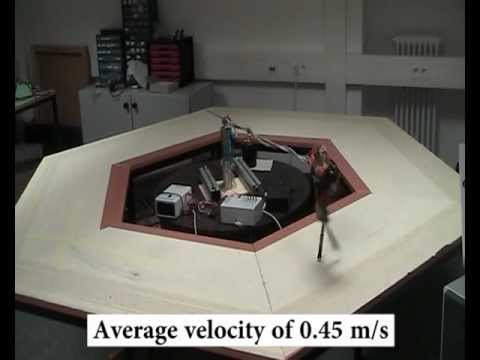

In [25]:
from IPython.display import YouTubeVideo
YouTubeVideo('ualnbKfkc3Q')

## 3. One dimensional example

In this example we show how GPyOpt works in a one-dimensional example a bit more difficult that the one we analyzed in Section 3. Let's consider here the Forrester function 

$$f(x) =(6x-2)^2 \sin(12x-4)$$ defined on the interval $[0, 1]$. 

The minimum of this function is located at $x_{min}=0.78$. The Forrester function is part of the benchmark of functions of GPyOpt. To create the true function, the perturbed version and boundaries of the problem you need to run the following cell. 

In [21]:
%pylab inline  
import GPy
import GPyOpt

# Create the true and perturbed Forrester function and the boundaries of the problem
f_true = GPyOpt.objective_examples.experiments1d.forrester()          # noisy version
bounds = [{'name': 'var_1', 'type': 'continuous', 'domain': (0,1)}]  # problem constrains 

Populating the interactive namespace from numpy and matplotlib


We plot the true Forrester function.

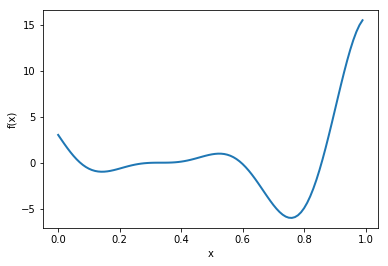

In [24]:
f_true.plot()

As we did in Section 3, we need to create the GPyOpt object that will run the optimization. We specify the function, the boundaries and we add the type of acquisition function to use. 

In [26]:
# Creates GPyOpt object with the model and anquisition fucntion
seed(123)
myBopt = GPyOpt.methods.BayesianOptimization(f=f_true.f,            # function to optimize       
                                             domain=bounds,        # box-constrains of the problem
                                             acquisition_type='EI',
                                             exact_feval = True) # Selects the Expected improvement

Now we want to run the optimization. Apart from the number of iterations you can select 
how do you want to optimize the acquisition function. You can run a number of local optimizers (acqu_optimize_restart) at random or in grid (acqu_optimize_method).     

In [27]:
# Run the optimization
max_iter = 15     # evaluation budget
max_time = 60     # time budget 
eps      = 10e-6  # Minimum allows distance between the last two observations

myBopt.run_optimization(max_iter, max_time, eps)                     

When the optimization is done you should receive a message describing if the method converged or if the maximum number of iterations was reached. In one dimensional examples, you can see the result of the optimization as follows.

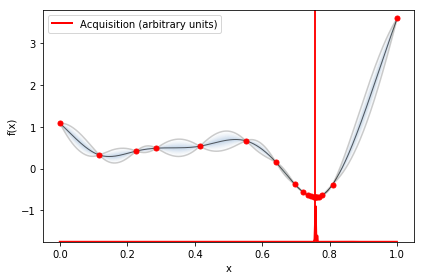

In [28]:
myBopt.plot_acquisition()

In problems of any dimension two evaluations plots are available.

* The distance between the last two observations.

* The value of $f$ at the best location previous to each iteration.

To see these plots just run the following cell.

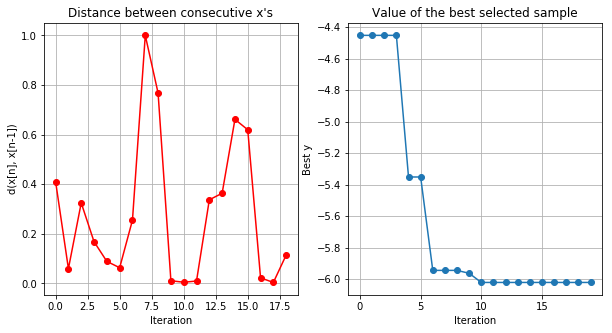

In [30]:
myBopt.plot_convergence()

Now let's make a video to track what the algorithm is doing in each iteration. Let's use the LCB in this case with parameter equal to 2.

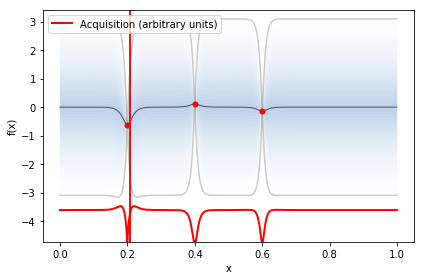

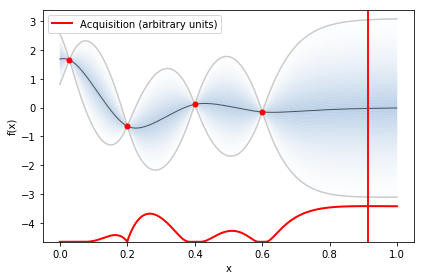

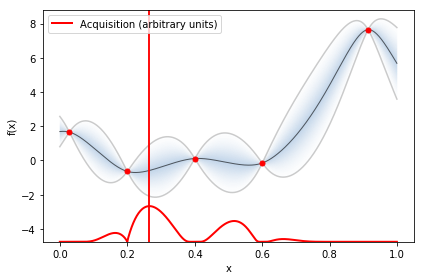

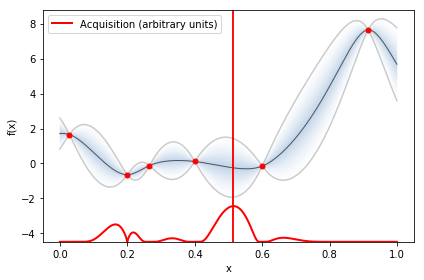

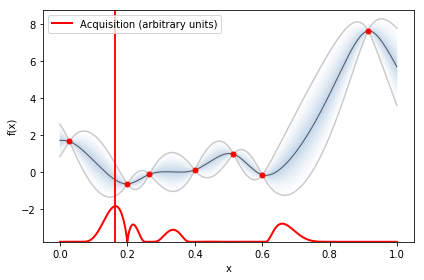

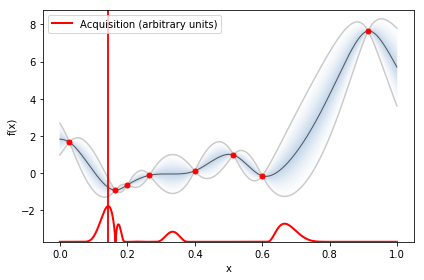

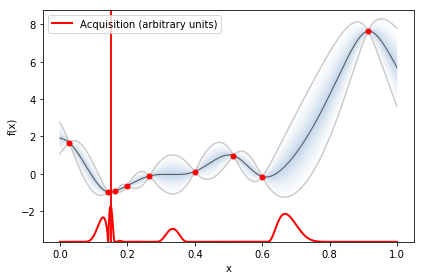

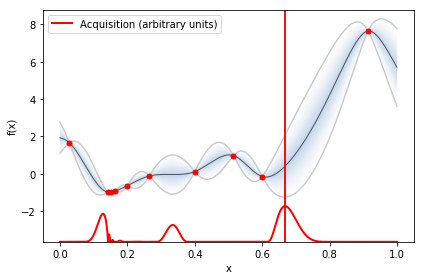

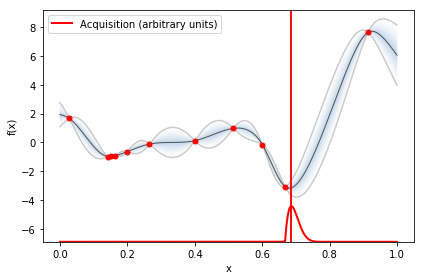

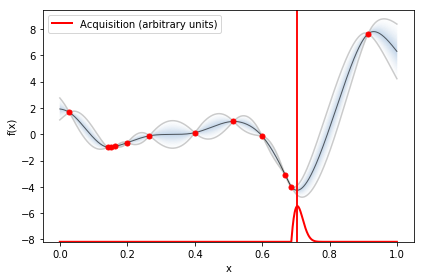

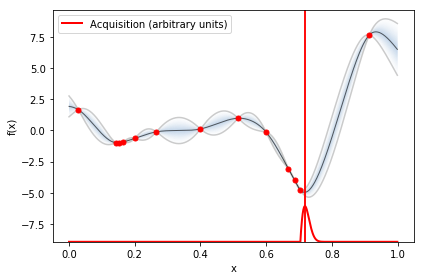

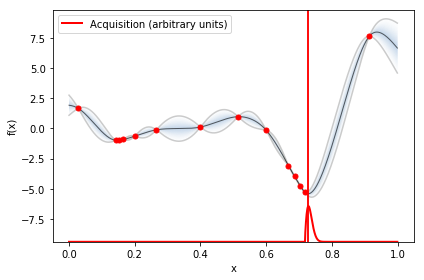

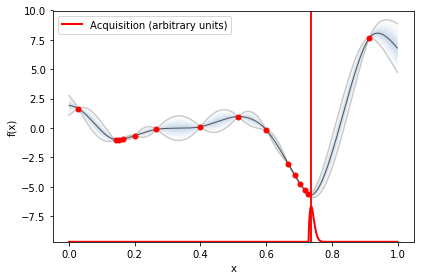

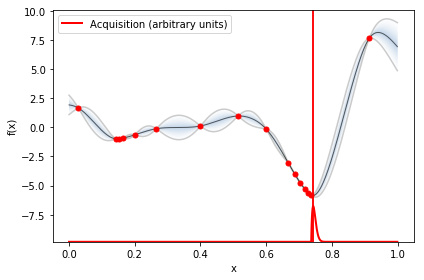

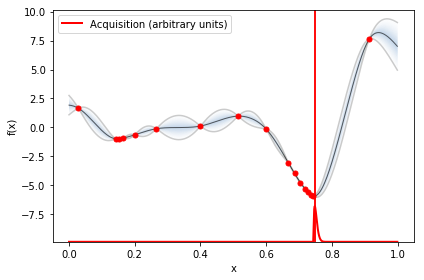

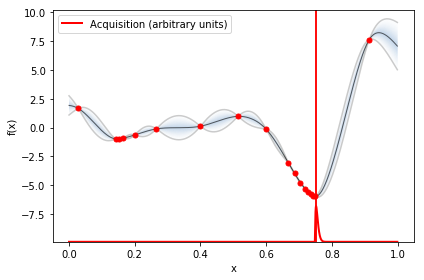

In [33]:
# starts the optimization, 
import numpy as np
X_initial = np.array([[0.2],[0.4],[0.6]])

iterBopt = GPyOpt.methods.BayesianOptimization(f=f_true.f,                 
                                             domain=bounds,        
                                             acquisition_type='EI',
                                             X = X_initial,
                                             exact_feval = True,
                                             normalize_Y = False,
                                             acquisition_jitter = 0.01)

iterBopt.model.model.kern.variance.constrain_fixed(2.5)

iterBopt.plot_acquisition('./figures/iteration%.03i.png' % (0))

from IPython.display import clear_output
N_iter = 15

for i in range(N_iter):
    clear_output()
    iterBopt.run_optimization(max_iter=1) 
    iterBopt.plot_acquisition('./figures/iteration%.03i.png' % (i + 1))

## 4. Two dimensional example

Next, we try a 2-dimensional example. In this case we minimize the use the Six-hump camel function 

$$f(x_1,x_2) = \left(4-2.1x_1^2 = \frac{x_1^4}{3} \right)x_1^2 + x_1x_2 + (-4 +4x_2^2)x_2^2,$$

in $[-3,3]\times [-2,2]$. This functions has two global minimum, at $(0.0898,-0.7126)$ and $(-0.0898,0.7126)$. As in the previous case we create the function, which is already in GPyOpt. In this case we generate observations of the function perturbed with white noise of $sd=0.1$.

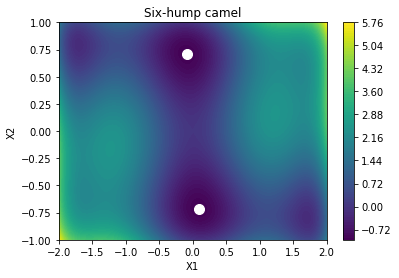

In [36]:
# create the object function
f_true = GPyOpt.objective_examples.experiments2d.sixhumpcamel()
f_sim = GPyOpt.objective_examples.experiments2d.sixhumpcamel(sd = 0.1)
bounds =[{'name': 'var_1', 'type': 'continuous', 'domain': f_true.bounds[0]},
         {'name': 'var_2', 'type': 'continuous', 'domain': f_true.bounds[1]}]
f_true.plot()

We create the GPyOpt object. In this case we use the Lower Confidence bound acquisition function to solve the problem.

In [37]:
# Creates three identical objects that we will later use to compare the optimization strategies 
myBopt2D = GPyOpt.methods.BayesianOptimization(f_sim.f,
                                              domain=bounds,
                                              model_type = 'GP',
                                              acquisition_type='LCB',  
                                              normalize_Y = True,
                                              acquisition_weight = 2)    

The set cost function is ignored! LBC acquisition does not make sense with cost.


 We run the optimization for 40 iterations and show the evaluation plot and the acquisition function.

In [41]:
# runs the optimization for the three methods
max_iter = 80  # maximum time 40 iterations
max_time = 60  # maximum time 60 seconds

myBopt2D.run_optimization(max_iter,max_time,verbosity=False)            

Finally, we plot the acquisition function and the convergence plot.

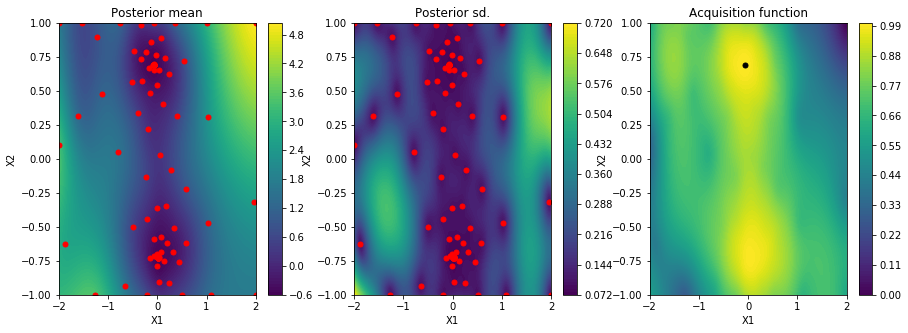

In [42]:
myBopt2D.plot_acquisition() 

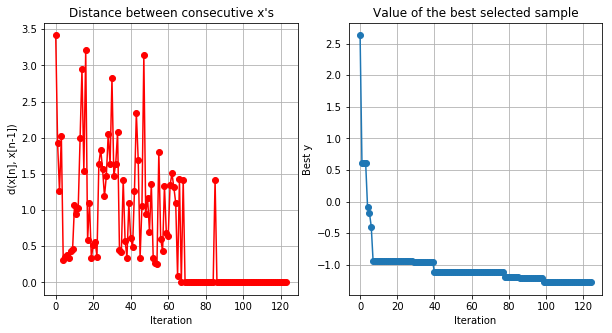

In [43]:
myBopt2D.plot_convergence()